In [57]:
import functions 

import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

In [7]:
def prepare_for_plot(dfcount, column, landcover, new_name):
    if column =='count':
        melted = pd.melt(dfcount, id_vars=['D', 'D_year', 'D_month'], var_name='elevation', value_name=new_name) 
        melted = melted.rename(columns={'D_year': 'year', 'D_month': 'month'})
    if column == 'volume':
        melted = pd.melt(dfcount, id_vars=['year', 'month'], var_name='elevation', value_name=new_name)
    
    melted['elevation'] = melted['elevation'].astype(str).str.extract(r'^(\d+)')[0].astype(int)
    melted['elevation_bin'] = melted.apply(functions.bin_elevation500, axis=1)
    # melted = melted.sort_values('elevation_bin')
    melted['date_id'] = melted['year'].astype(str) + "_" + melted['month'].astype(str) + "_" + melted['elevation'].astype(str)
    melted = melted.sort_values('date_id')
    melted['landcover'] = landcover
    return melted 

# TL case



In [41]:
output_path = f'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/TL/'

# ------ Qstl - volume of sediments 

TL1 = pd.read_csv(output_path + f'langtang_monthly_sum_elevation_Qstl_1landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
TL2 = pd.read_csv(output_path + f'langtang_monthly_sum_elevation_Qstl_2landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
TL3 = pd.read_csv(output_path + f'langtang_monthly_sum_elevation_Qstl_3landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
TL4 = pd.read_csv(output_path + f'langtang_monthly_sum_elevation_Qstl_4landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)
TL5 = pd.read_csv(output_path + f'langtang_monthly_sum_elevation_Qstl_5landcover_mm.csv', index_col = 0).fillna(0).reset_index().drop(['folder'], axis = 1)

TL1 = prepare_for_plot(TL1, 'volume', 'landcover 1', 'Qstl')#[['Q100', 'date_id']]
TL2 = prepare_for_plot(TL2, 'volume', 'landcover 2', 'Qstl')#[['Q100', 'date_id']]
TL3 = prepare_for_plot(TL3, 'volume', 'landcover 3', 'Qstl')#[['Q100', 'date_id']]
TL4 = prepare_for_plot(TL4, 'volume', 'landcover 4', 'Qstl')#[['Q100', 'date_id']]
TL5 = prepare_for_plot(TL5, 'volume', 'landcover 5', 'Qstl')#[['Q100', 'date_id']]


# SL DAILY

In [43]:
# here: import SL daily files for the different percentiles - here is the pattern where it is stored 

# '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_daily/output_20percent/langtang_monthly_sum_elevation_Q100_20percent_1landcover_mm.csv'
# then make the same 

In [44]:
# Base path for SL daily output
sl_base_path = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_daily/'

# Define percentiles and landcovers
percentiles = ['20percent', '30percent', '40percent', '50percent', '60percent']
landcovers = [1, 2, 3, 4, 5]

# Read all SL Q100 files
sl_data = {}
for pct in percentiles:
    for lc in landcovers:
        file_path = f'{sl_base_path}output_{pct}/langtang_monthly_sum_elevation_Q100_{pct}_{lc}landcover_mm.csv'
        key = f'SL_{pct}_{lc}landcover'
        sl_data[key] = pd.read_csv(file_path, index_col=0).fillna(0).reset_index().drop(['folder'], axis=1)

        # Apply the prepare_for_plot function
        sl_data[key] = prepare_for_plot(sl_data[key], 'volume', f'landcover {lc}', 'Q100')


In [45]:
lc1_20p = sl_data['SL_20percent_1landcover']
lc1_30p = sl_data['SL_30percent_1landcover']
lc1_40p = sl_data['SL_40percent_1landcover']
lc1_50p = sl_data['SL_50percent_1landcover']
lc1_60p = sl_data['SL_60percent_1landcover']

In [46]:
# Function to combine all percentiles for one landcover
def combine_percentiles_for_landcover(landcover_num, sl_data):
    # Get the base dataframe (using 20percent as starting point)
    base_key = f'SL_20percent_{landcover_num}landcover'
    combined_df = sl_data[base_key][['year', 'month', 'elevation', 'elevation_bin', 'date_id', 'landcover']].copy()
    # Add Q100 columns for ALL percentiles
    for pct in ['20percent', '30percent', '40percent', '50percent', '60percent']:
        key = f'SL_{pct}_{landcover_num}landcover'
        combined_df[f'Q100_{pct}'] = sl_data[key]['Q100'].values  # Use .values to avoid index issues
    return combined_df


In [47]:
combined_landcovers = {}
for lc in [1, 2, 3, 4, 5]:
    combined_landcovers[f'landcover_{lc}'] = combine_percentiles_for_landcover(lc, sl_data)



In [48]:
# Function to add TL Qstl data to the combined SL dataframe
def add_tl_data_to_combined(combined_df, tl_df):
    # Merge on the common columns to align the data
    merged_df = combined_df.merge(
        tl_df[['year', 'month', 'elevation', 'elevation_bin', 'date_id', 'Qstl']],
        on=['year', 'month', 'elevation', 'elevation_bin', 'date_id'],
        how='left'
    )
    return merged_df

# Add TL data to each landcover's combined dataframe
tl_dataframes = [TL1, TL2, TL3, TL4, TL5]

for i, lc in enumerate([1, 2, 3, 4, 5]):
    combined_landcovers[f'landcover_{lc}'] = add_tl_data_to_combined(
        combined_landcovers[f'landcover_{lc}'],
        tl_dataframes[i]
    )

In [92]:
def calculate_sl_to_tl_percentages(df):
    """
    Calculate the percentage of SL (Q100) to TL (Qstl) for each percentile
    """
    df_with_percentages = df.copy()
    # Calculate percentage for each percentile
    percentiles = ['20percent', '30percent', '40percent', '50percent', '60percent']
    for pct in percentiles:
        q100_col = f'Q100_{pct}'
        percentage_col = f'SL_to_TL_{pct}'
        # Calculate (Q100 / Qstl) * 100, handle division by zero
        df_with_percentages[percentage_col] = (
            df_with_percentages[q100_col] / df_with_percentages['Qstl'] * 100
        ).fillna(0)  # Fill NaN (from 0/0) with 0
        # Optional: Replace infinite values with a large number or NaN
        df_with_percentages[percentage_col] = df_with_percentages[percentage_col].replace([float('inf'), -float('inf')], 0)
    return df_with_percentages

# Apply the function to all landcover dataframes
for lc in [1, 2, 3, 4, 5]:
    combined_landcovers[f'landcover_{lc}'] = calculate_sl_to_tl_percentages(combined_landcovers[f'landcover_{lc}'])

In [93]:
# Now you can access each landcover's combined data:
lc1_combined = combined_landcovers['landcover_1']
lc2_combined = combined_landcovers['landcover_2']
lc3_combined = combined_landcovers['landcover_3']
lc4_combined = combined_landcovers['landcover_4']
lc5_combined = combined_landcovers['landcover_5']


In [94]:
lc1_combined

,year,month,elevation,elevation_bin,date_id,landcover,Q100_20percent,Q100_30percent,Q100_40percent,Q100_50percent,Q100_60percent,Qstl,SL_to_TL_20percent,SL_to_TL_30percent,SL_to_TL_40percent,SL_to_TL_50percent,SL_to_TL_60percent
0,1989,10,2448,2500,1989_10_2448,landcover 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1989,10,2613,2500 - 3000,1989_10_2613,landcover 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1989,10,3360,3000 - 3500,1989_10_3360,landcover 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1989,10,3421,3000 - 3500,1989_10_3421,landcover 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1989,10,3695,3500 - 4000,1989_10_3695,landcover 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20639,2022,9,5763,5500 - 6000,2022_9_5763,landcover 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20640,2022,9,5859,5500 - 6000,2022_9_5859,landcover 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20641,2022,9,5870,5500 - 6000,2022_9_5870,landcover 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20642,2022,9,5936,5500 - 6000,2022_9_5936,landcover 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


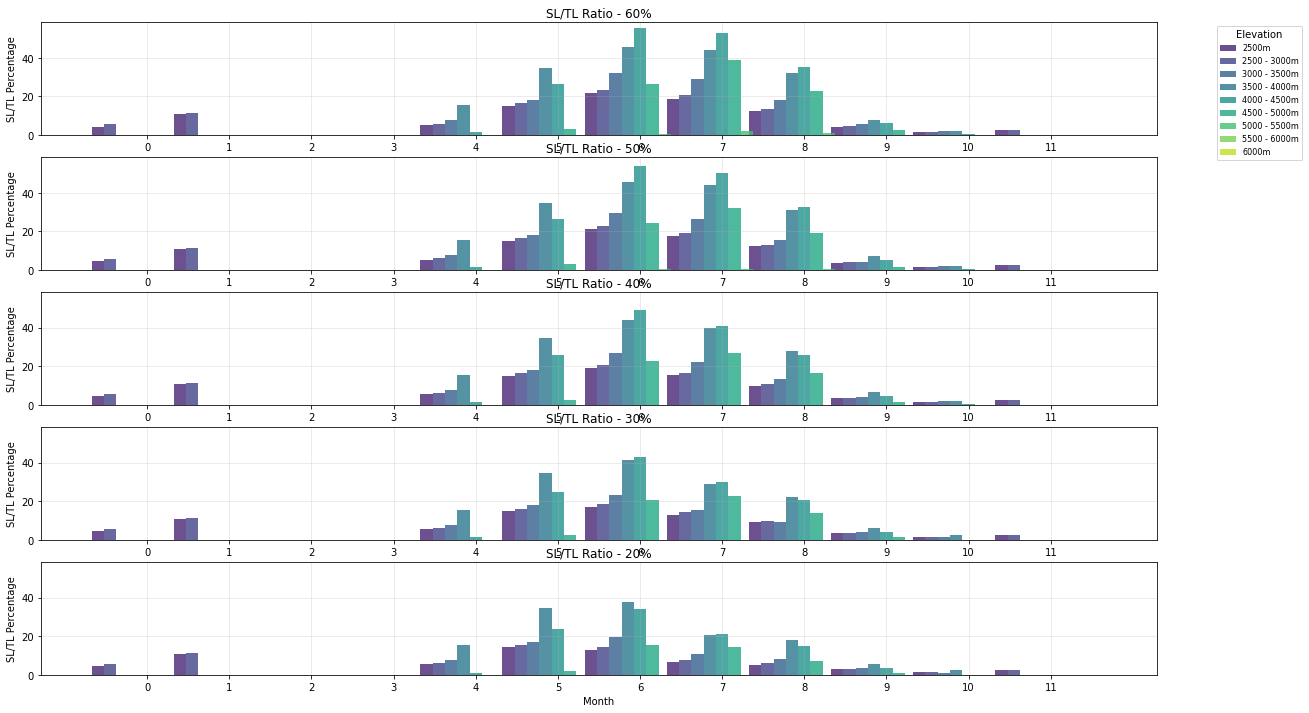

In [98]:
# Get landcover 1 data
lc1_data = combined_landcovers['landcover_1']

# Set up the mosaic layout for 5 panels
fig = plt.figure(figsize=(20, 12))
mosaic = """
        A
        B
        C
        D
        E
        """

axes = fig.subplot_mosaic(mosaic, sharey=True)

# Define percentiles and corresponding axes
percentiles= ['60percent', '50percent', '40percent', '30percent', '20percent']
panel_keys = ['A', 'B', 'C', 'D', 'E']

# Color palette for elevation bins
elevation_bins = sorted(lc1_data['elevation_bin'].unique())
colors = sns.color_palette("viridis", len(elevation_bins))

for i, (pct, ax_key) in enumerate(zip(percentiles, panel_keys)):
    ax = axes[ax_key]

    # Get the percentage column for this percentile
    pct_col = f'SL_to_TL_{pct}'

    # Prepare data for grouped bar chart
    months = sorted(lc1_data['month'].unique())
    x_pos = np.arange(len(months))
    bar_width = 0.15  # Width of each bar
    # Plot bars for each elevation bin
    for j, elev_bin in enumerate(elevation_bins):
        elev_data = lc1_data[lc1_data['elevation_bin'] == elev_bin]
        monthly_means = elev_data.groupby('month')[pct_col].mean()

        # Align data with months (fill missing with 0)
        values = [monthly_means.get(month, 0) for month in months]

        # Position bars
        x_positions = x_pos + (j - len(elevation_bins)/2 + 0.5) * bar_width

        ax.bar(x_positions, values, bar_width,
               label=f'{elev_bin}m' if i == 0 else "",
                color=colors[j], alpha=0.8)

    # Customize subplot
    ax.set_title(f'SL/TL Ratio - {pct.replace("percent", "%")}', fontsize=12)
    ax.set_xlabel('Month', fontsize=10)
    ax.set_ylabel('SL/TL Percentage', fontsize=10)
    ax.set_xticks(x_pos)
    # ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    ax.grid(True, alpha=0.3)
    # Add legend only to first panel
    if i == 0:
        ax.legend(title='Elevation', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)



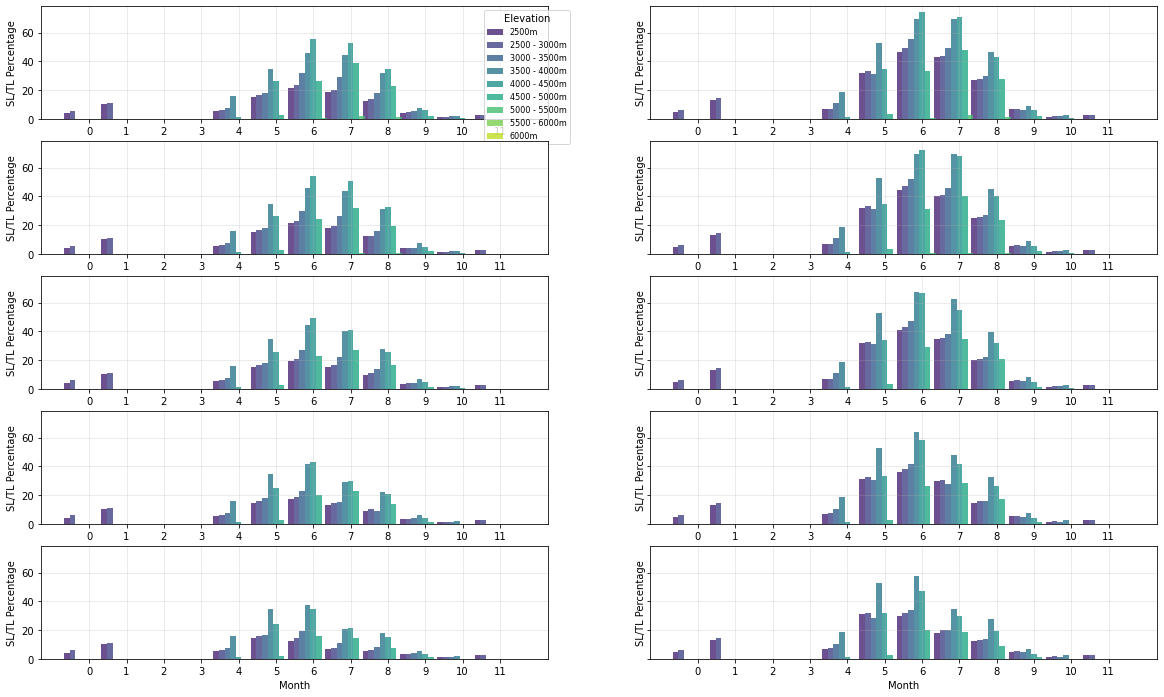

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get landcover 1 and 2 data
lc1_data = combined_landcovers['landcover_1']
lc2_data = combined_landcovers['landcover_2']

# Set up the mosaic layout for 10 panels (5 for each landcover)
fig = plt.figure(figsize=(20, 12))
mosaic = """
        Aa
        Bb
        Cc
        Dd
        Ee
        """
axes = fig.subplot_mosaic(mosaic, sharey = True)

# Color palette for elevation bins
elevation_bins = sorted(lc1_data['elevation_bin'].unique())
colors = sns.color_palette("viridis", len(elevation_bins))

# Prepare common data
months = sorted(lc1_data['month'].unique())
x_pos = np.arange(len(months))
bar_width = 0.15

def plot_panel(ax, data, pct_col, title, show_legend=False):
    # Plot bars for each elevation bin
    for j, elev_bin in enumerate(elevation_bins):
        elev_data = data[data['elevation_bin'] == elev_bin]
        monthly_means = elev_data.groupby('month')[pct_col].mean()
        
        # Align data with months (fill missing with 0)
        values = [monthly_means.get(month, 0) for month in months]
        
        # Position bars
        x_positions = x_pos + (j - len(elevation_bins)/2 + 0.5) * bar_width
        
        ax.bar(x_positions, values, bar_width, 
               label=f'{elev_bin}m' if show_legend else "", 
               color=colors[j], alpha=0.8)
    
    # Customize subplot
    # ax.set_title(title, fontsize=12)
    ax.set_xlabel('Month', fontsize=10)
    ax.set_ylabel('SL/TL Percentage', fontsize=10)
    ax.set_xticks(x_pos)
    # ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    ax.grid(True, alpha=0.3)
    
    if show_legend:
        ax.legend(title='Elevation', bbox_to_anchor=(1.05, 1), loc='upper right', fontsize=8)

# Landcover 1 panels (A, B, C, D, E)
plot_panel(axes['A'], lc1_data, 'SL_to_TL_60percent', 'Landcover 1 - 60%', show_legend=True)
plot_panel(axes['B'], lc1_data, 'SL_to_TL_50percent', 'Landcover 1 - 50%')
plot_panel(axes['C'], lc1_data, 'SL_to_TL_40percent', 'Landcover 1 - 40%')
plot_panel(axes['D'], lc1_data, 'SL_to_TL_30percent', 'Landcover 1 - 30%')
plot_panel(axes['E'], lc1_data, 'SL_to_TL_20percent', 'Landcover 1 - 20%')

# Landcover 2 panels (a, b, c, d, e)
plot_panel(axes['a'], lc2_data, 'SL_to_TL_60percent', 'Landcover 2 - 60%')
plot_panel(axes['b'], lc2_data, 'SL_to_TL_50percent', 'Landcover 2 - 50%')
plot_panel(axes['c'], lc2_data, 'SL_to_TL_40percent', 'Landcover 2 - 40%')
plot_panel(axes['d'], lc2_data, 'SL_to_TL_30percent', 'Landcover 2 - 30%')
plot_panel(axes['e'], lc2_data, 'SL_to_TL_20percent', 'Landcover 2 - 20%')

# plt.suptitle('SL/TL Ratio Comparison: Landcover 1 vs Landcover 2', fontsize=16, y=0.95)
# plt.tight_layout()

# # Save plot
# outpath = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/processing_pipeline/testplots_by_claude/'
# plt.savefig(outpath + 'sl_tl_ratio_barcharts_landcover1.png', dpi=300, bbox_inches='tight')
# plt.show()

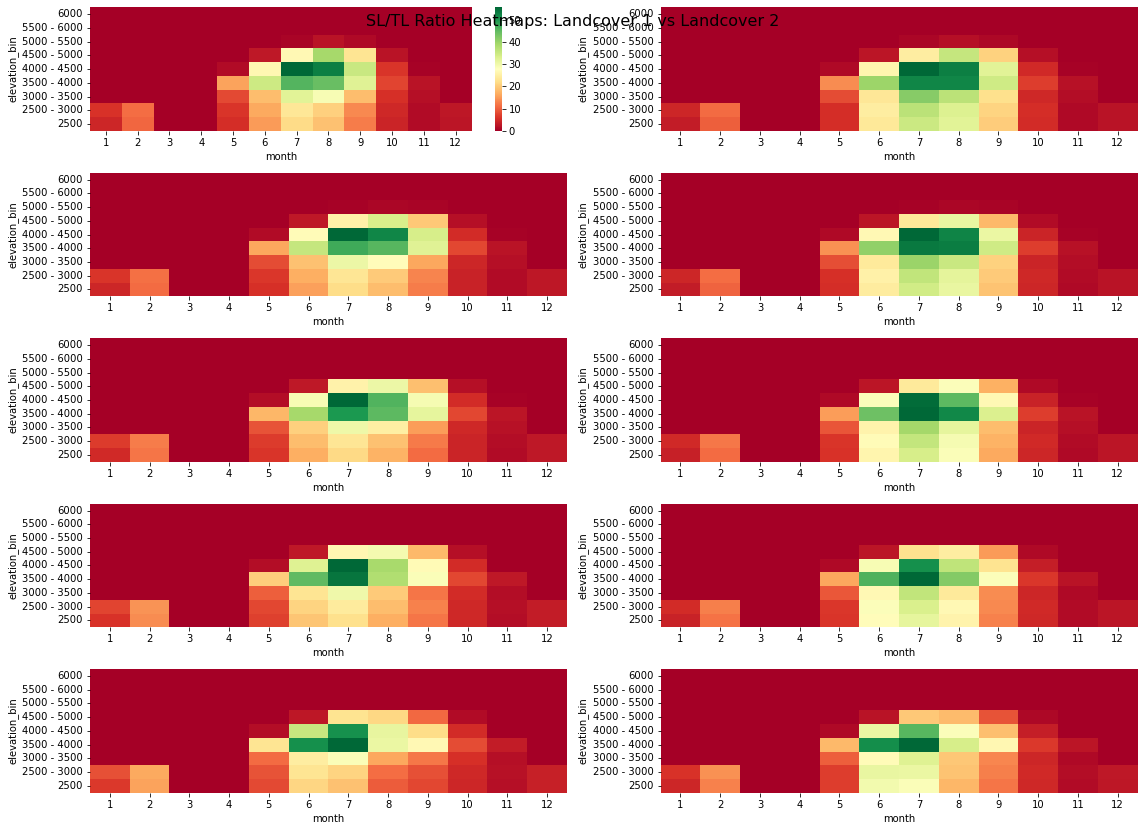

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get landcover 1 and 2 data
lc1_data = combined_landcovers['landcover_1']
lc2_data = combined_landcovers['landcover_2']

# Set up the mosaic layout for 10 panels (5 for each landcover)
fig = plt.figure(figsize=(16, 12))
mosaic = """
        Aa
        Bb
        Cc
        Dd
        Ee
        """
axes = fig.subplot_mosaic(mosaic)

def plot_panel(ax, data, pct_col, title, show_legend=False):
    # Prepare data for heatmap
    pivot_data = data.pivot_table(
        values=pct_col, 
        index='elevation_bin', 
        columns='month', 
        aggfunc='mean'
    ).fillna(0)
    
    # Sort elevation bins from high to low (6000 at top, 2500 at bottom)
    pivot_data = pivot_data.sort_index(ascending=False)
    
    # Create heatmap
    sns.heatmap(pivot_data, 
                ax=ax,
                cmap='RdYlGn',  # Red = low SL/TL (high limitation), Green = high SL/TL (low limitation)
                cbar=show_legend,  # Only show colorbar on first panel
                annot=False,  # Set to True if you want values displayed
                fmt='.0f')
                # xticklabels=['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'],
                # yticklabels=[f'{int(elev)}m' for elev in pivot_data.index])
    
    # Customize subplot
    # ax.set_title(title, fontsize=12)
    # ax.set_xlabel('Month', fontsize=10)
    # ax.set_ylabel('Elevation', fontsize=10)

# Landcover 1 panels (A, B, C, D, E)
plot_panel(axes['A'], lc1_data, 'SL_to_TL_60percent', 'Landcover 1 - 60%', show_legend=True)
plot_panel(axes['B'], lc1_data, 'SL_to_TL_50percent', 'Landcover 1 - 50%')
plot_panel(axes['C'], lc1_data, 'SL_to_TL_40percent', 'Landcover 1 - 40%')
plot_panel(axes['D'], lc1_data, 'SL_to_TL_30percent', 'Landcover 1 - 30%')
plot_panel(axes['E'], lc1_data, 'SL_to_TL_20percent', 'Landcover 1 - 20%')

# Landcover 2 panels (a, b, c, d, e)
plot_panel(axes['a'], lc2_data, 'SL_to_TL_60percent', 'Landcover 2 - 60%')
plot_panel(axes['b'], lc2_data, 'SL_to_TL_50percent', 'Landcover 2 - 50%')
plot_panel(axes['c'], lc2_data, 'SL_to_TL_40percent', 'Landcover 2 - 40%')
plot_panel(axes['d'], lc2_data, 'SL_to_TL_30percent', 'Landcover 2 - 30%')
plot_panel(axes['e'], lc2_data, 'SL_to_TL_20percent', 'Landcover 2 - 20%')

plt.suptitle('SL/TL Ratio Heatmaps: Landcover 1 vs Landcover 2', fontsize=16, y=0.95)
plt.tight_layout()

# # Save plot
# outpath = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/processing_pipeline/testplots_by_claude/'
# plt.savefig(outpath + 'sl_tl_ratio_heatmaps_landcover1_vs_2.png', dpi=300, bbox_inches='tight')
# plt.show()

In [109]:
def plot_panel(ax, data, pct_col, title, show_yticks=False, show_xticks=False, show_legend = False):
    # Plot bars for each elevation bin
    for j, elev_bin in enumerate(elevation_bins):
        elev_data = data[data['elevation_bin'] == elev_bin]
        monthly_means = elev_data.groupby('month')[pct_col].mean()
        
        # Align data with months (fill missing with 0)
        values = [monthly_means.get(month, 0) for month in months]
        
        # Position bars
        x_positions = x_pos + (j - len(elevation_bins)/2 + 0.5) * bar_width
        
        ax.bar(x_positions, values, bar_width, 
               label=f'{elev_bin}m' if show_legend else "", 
               color=colors[j], alpha=0.8)
    
    # Customize subplot
    # ax.set_title(title, fontsize=12)
    ax.set_xlabel('Month', fontsize=10)
    ax.set_ylabel('SL/TL Percentage', fontsize=10)
    ax.set_xticks(x_pos)
    # ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    ax.grid(True, alpha=0.3)
    
    if show_legend:
        ax.legend(title='Elevation', bbox_to_anchor=(1.05, 1), loc='upper right', fontsize=8)


In [119]:

def plot_panel(ax, data, pct_col, title, show_legend=False, show_yticks=False, show_xticks=False):
    # Prepare data for heatmap
    pivot_data = data.pivot_table(
        values=pct_col, 
        index='elevation_bin', 
        columns='month', 
        aggfunc='mean'
    )
    
    # Sort elevation bins from high to low (6000 at top, 2500 at bottom)
    pivot_data = pivot_data.sort_index(ascending=False)
    
    # Create y-tick labels handling both numeric and string elevation bins
    if show_yticks:
        ytick_labels = []
        for elev in pivot_data.index:
            if isinstance(elev, str):
                ytick_labels.append(f'{elev}m')
            else:
                ytick_labels.append(f'{int(elev)}m')
    else:
        ytick_labels = False
    
    # Create x-tick labels
    xtick_labels = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'] if show_xticks else False
    
    # Create heatmap
    sns.heatmap(pivot_data, 
                ax=ax,
                cmap='coolwarm',  # Red = low SL/TL (high limitation), Green = high SL/TL (low limitation)
                cbar=show_legend,  # Only show colorbar on first panel
                annot=False,  # Set to True if you want values displayed
                fmt='.0f',
                xticklabels=xtick_labels,
                yticklabels=ytick_labels)
    
    # Customize subplot
    ax.set_title(title, fontsize=12)
    if show_xticks:
        ax.set_xlabel('Month', fontsize=10)
    if show_yticks:
        ax.set_ylabel('Elevation', fontsize=10)


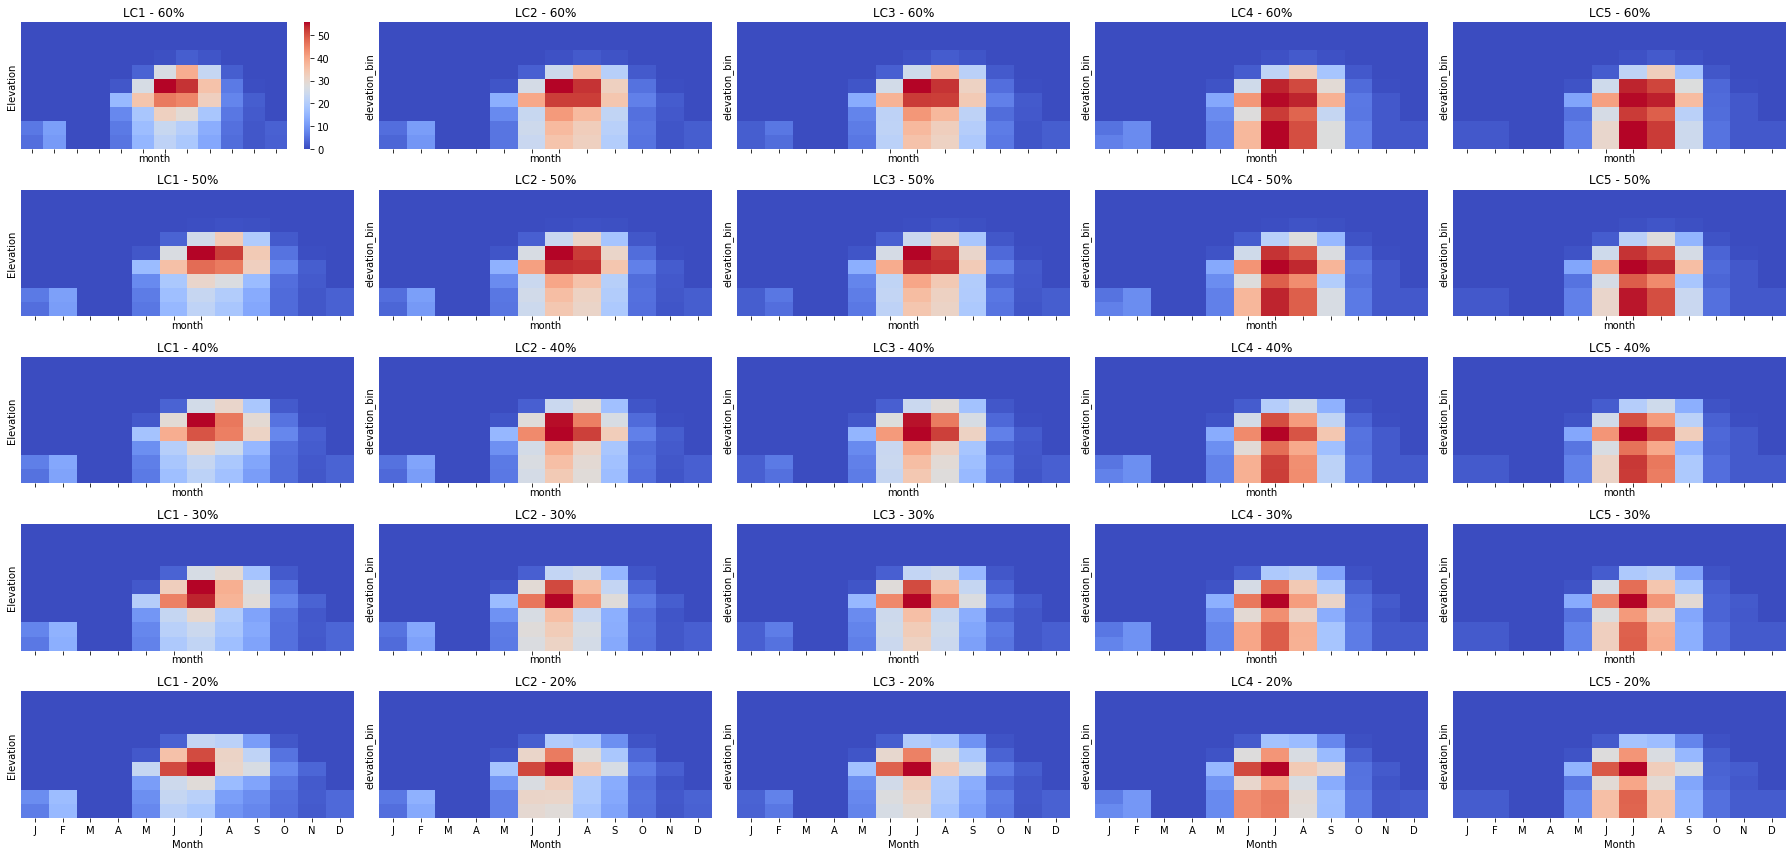

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get all landcover data
lc1_data = combined_landcovers['landcover_1']
lc2_data = combined_landcovers['landcover_2']
lc3_data = combined_landcovers['landcover_3']
lc4_data = combined_landcovers['landcover_4']
lc5_data = combined_landcovers['landcover_5']

# cmap = plt.cm.coolwarm

# Set up the mosaic layout for 25 panels (5 landcovers x 5 percentiles)
fig = plt.figure(figsize=(25, 12))
mosaic = """
        AaBbC
        DdEeF
        GgHhI
        JjKkL
        MmNnO
        """
axes = fig.subplot_mosaic(mosaic, sharex = True, sharey=True)

# Row 1: 60% - All landcovers
plot_panel(axes['A'], lc1_data, 'SL_to_TL_60percent', 'LC1 - 60%', show_legend=True, show_yticks=True)
plot_panel(axes['a'], lc2_data, 'SL_to_TL_60percent', 'LC2 - 60%')
plot_panel(axes['B'], lc3_data, 'SL_to_TL_60percent', 'LC3 - 60%')
plot_panel(axes['b'], lc4_data, 'SL_to_TL_60percent', 'LC4 - 60%')
plot_panel(axes['C'], lc5_data, 'SL_to_TL_60percent', 'LC5 - 60%')

# Row 2: 50% - All landcovers
plot_panel(axes['D'], lc1_data, 'SL_to_TL_50percent', 'LC1 - 50%', show_yticks=True)
plot_panel(axes['d'], lc2_data, 'SL_to_TL_50percent', 'LC2 - 50%')
plot_panel(axes['E'], lc3_data, 'SL_to_TL_50percent', 'LC3 - 50%')
plot_panel(axes['e'], lc4_data, 'SL_to_TL_50percent', 'LC4 - 50%')
plot_panel(axes['F'], lc5_data, 'SL_to_TL_50percent', 'LC5 - 50%')

# Row 3: 40% - All landcovers
plot_panel(axes['G'], lc1_data, 'SL_to_TL_40percent', 'LC1 - 40%', show_yticks=True)
plot_panel(axes['g'], lc2_data, 'SL_to_TL_40percent', 'LC2 - 40%')
plot_panel(axes['H'], lc3_data, 'SL_to_TL_40percent', 'LC3 - 40%')
plot_panel(axes['h'], lc4_data, 'SL_to_TL_40percent', 'LC4 - 40%')
plot_panel(axes['I'], lc5_data, 'SL_to_TL_40percent', 'LC5 - 40%')

# Row 4: 30% - All landcovers
plot_panel(axes['J'], lc1_data, 'SL_to_TL_30percent', 'LC1 - 30%', show_yticks=True)
plot_panel(axes['j'], lc2_data, 'SL_to_TL_30percent', 'LC2 - 30%')
plot_panel(axes['K'], lc3_data, 'SL_to_TL_30percent', 'LC3 - 30%')
plot_panel(axes['k'], lc4_data, 'SL_to_TL_30percent', 'LC4 - 30%')
plot_panel(axes['L'], lc5_data, 'SL_to_TL_30percent', 'LC5 - 30%')

# Row 5: 20% - All landcovers (bottom row shows x-ticks)
plot_panel(axes['M'], lc1_data, 'SL_to_TL_20percent', 'LC1 - 20%', show_yticks=True, show_xticks=True)
plot_panel(axes['m'], lc2_data, 'SL_to_TL_20percent', 'LC2 - 20%', show_xticks=True)
plot_panel(axes['N'], lc3_data, 'SL_to_TL_20percent', 'LC3 - 20%', show_xticks=True)
plot_panel(axes['n'], lc4_data, 'SL_to_TL_20percent', 'LC4 - 20%', show_xticks=True)
plot_panel(axes['O'], lc5_data, 'SL_to_TL_20percent', 'LC5 - 20%', show_xticks=True)

# plt.suptitle('SL/TL Ratio Heatmaps: All Landcovers by Percentile Thresholds', fontsize=16, y=0.95)
plt.tight_layout()

# # Save plot
# outpath = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/processing_pipeline/testplots_by_claude/'
# plt.savefig(outpath + 'sl_tl_ratio_heatmaps_landcover1_vs_2.png', dpi=300, bbox_inches='tight')
# plt.show()